<a href="https://colab.research.google.com/github/n4b1lAh/MachineLearning/blob/main/x_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install -q kaggle

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!ls "/content/drive/MyDrive/Colab"


archive.zip  lungcancer.zip  roverDataset.zip


In [11]:
import zipfile
import os

# Correct file path to your zip file
zip_path = '/content/drive/MyDrive/Colab/archive.zip'

# Destination folder for extracted files
extract_to = '/content/dataset/'

# Ensure the destination folder exists
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Dataset extracted to {extract_to}")


Dataset extracted to /content/dataset/


In [12]:
import os

dataset_path = '/content/dataset'
print(f"Contents of {dataset_path}:")
print(os.listdir(dataset_path))


Contents of /content/dataset:
['chest_xray']


In [13]:
train_dir = '/content/dataset/chest_xray/train'
val_dir = '/content/dataset/chest_xray/val'
test_dir = '/content/dataset/chest_xray/test'

# Define the labels
labels = ['NORMAL', 'PNEUMONIA'] # Assuming these are the folder names within train, test and val



In [14]:
# Function to count files in each subdirectory
def count_files(dir_path):
    for category in os.listdir(dir_path):
        category_path = os.path.join(dir_path, category)
        num_files = len(os.listdir(category_path))
        print(f"{category}: {num_files} files")

# Count files in train, validation, and test sets

print('Train Set: \n' + '='*50)
count_files(train_dir)

print('\nValidation Set: \n' + '='*50)
count_files(val_dir)

print('\nTest Set: \n' + '='*50)
count_files(test_dir)


Train Set: 
NORMAL: 1341 files
PNEUMONIA: 3875 files

Validation Set: 
NORMAL: 8 files
PNEUMONIA: 8 files

Test Set: 
NORMAL: 234 files
PNEUMONIA: 390 files


In [15]:
def get_file_sizes(directory):
    file_sizes = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            size = os.path.getsize(file_path) / 1024 #bytes to KB
            file_sizes.append({'file': file_path, 'size_kb': round(size,3)})
    return file_sizes

##🔹 Why is This Useful?
##✅ Check dataset size → Helps to analyze how much storage the dataset is taking.
##✅ Detect large files → Useful if some files are too big and may slow down training.
##✅ Debugging → If there are missing or corrupted files, this function helps in verifying the dataset structure.

In [16]:
get_file_sizes(train_dir)[:5]

[{'file': '/content/dataset/chest_xray/train/NORMAL/IM-0614-0001.jpeg',
  'size_kb': 593.458},
 {'file': '/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-0616-0001.jpeg',
  'size_kb': 501.788},
 {'file': '/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-1303-0001.jpeg',
  'size_kb': 418.138},
 {'file': '/content/dataset/chest_xray/train/NORMAL/NORMAL2-IM-0830-0001.jpeg',
  'size_kb': 589.01},
 {'file': '/content/dataset/chest_xray/train/NORMAL/IM-0293-0001.jpeg',
  'size_kb': 374.679}]

In [17]:
def get_file_sizes(directory):
    file_sizes = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            size = os.path.getsize(file_path) / 1024 #bytes to KB
            file_sizes.append({'file': file_path, 'size_kb': round(size,3)})
    return file_sizes

def create_dataframe(path=None, labels=None):
    data = []
    for label in labels:
        category_path = os.path.join(path, label)
        file_sizes = get_file_sizes(category_path)
        data.extend(file_sizes)

    import pandas as pd #Import pandas inside function to avoid import errors
    df = pd.DataFrame(data)
    return df

In [18]:
train_df = create_dataframe(train_dir, labels)
test_df = create_dataframe(test_dir, labels)
val_df = create_dataframe(val_dir, labels)

print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 2)
shape of test_dir (624, 2)
shape of val_dir (16, 2)


In [19]:
train_df.head(3)

,file,size_kb
0,/content/dataset/chest_xray/train/NORMAL/IM-06...,593.458
1,/content/dataset/chest_xray/train/NORMAL/NORMA...,501.788
2,/content/dataset/chest_xray/train/NORMAL/NORMA...,418.138


In [20]:
def extract_label(file_path):
    if 'PNEUMONIA' in file_path:
        return 'pneumonia'
    elif 'NORMAL' in file_path:
        return 'normal'
    else:
        return 'unknown'

dict_dir_df = {'train': train_df,
               'val': val_df,
               'test': test_df}

In [21]:
for df in dict_dir_df.values():
    df['label'] = df['file'].apply(extract_label)

In [22]:
train_df.sample(3)

,file,size_kb,label
2940,/content/dataset/chest_xray/train/PNEUMONIA/pe...,142.608,pneumonia
494,/content/dataset/chest_xray/train/NORMAL/IM-05...,436.172,normal
218,/content/dataset/chest_xray/train/NORMAL/NORMA...,543.812,normal


In [23]:
def get_image_dimensions(file_path):
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        return (0, 0)

In [ ]:
for name, df in dict_dir_df.items():
    df['dimensions'] = df['file'].apply(get_image_dimensions)
    logging.info(f'{name} updated with dimensions.')

In [28]:
for name, df in dict_dir_df.items():
    filtered_dir = df[df['dimensions'].apply(lambda x: len(x) >= 3)]
    print(f'{name}:',filtered_dir.shape[0])

train: 0
val: 0
test: 0


In [29]:
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 4)
shape of test_dir (624, 4)
shape of val_dir (16, 4)


In [30]:
import pandas as pd # Add this line at the beginning of the cell

merged_df = pd.concat([train_df, val_df,test_df], ignore_index=True)
merged_df.shape

(5856, 4)

In [31]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split # import the function

train_df, test_df_full = train_test_split(merged_df, test_size=0.3,
                                    stratify = merged_df['label'], random_state=42)

test_df, val_df = train_test_split(test_df_full, test_size=0.5,
                                    stratify = test_df_full['label'], random_state=42)

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [32]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(4099, 4)
(878, 4)
(879, 4)


In [33]:
def preprocess_image(file_path, label, channels=3):

    img = tf.io.read_file(file_path)


    img = tf.image.decode_jpeg(img, channels=channels)


    img = tf.image.resize(img, [224, 224])


    img = tf.cast(img, tf.float32) / 255.0


    label = tf.where(tf.math.equal(label, 'normal'), 0, 1)


    return img, label

In [34]:
def color_jitter(image, brightness_factor=0.01, contrast_factor=0.01, seed=None):
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
    image = tf.image.random_contrast(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_saturation(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_hue(image, max_delta=0.1, seed=seed)

    return image

In [35]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [36]:
!pip install tensorflow #Install TensorFlow
import tensorflow as tf # Import TensorFlow library
!pip install matplotlib # Install matplotlib
import matplotlib.pyplot as plt # Import pyplot and alias it as plt

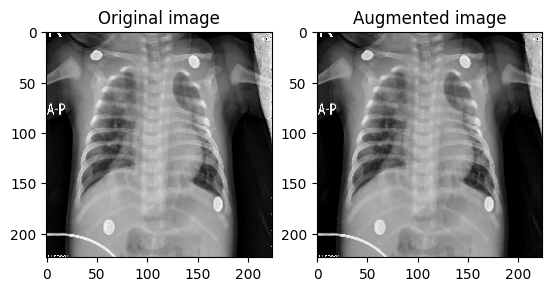

In [37]:
image_path = '/content/dataset/chest_xray/test/PNEUMONIA/person1610_virus_2793.jpeg' #Corrected the file path
img, label = preprocess_image(image_path,'pneumonia',channels=3)
color_jiter_test = color_jitter(img,seed=3)
visualize(img, color_jiter_test)

In [38]:
img.shape

TensorShape([224, 224, 3])

In [39]:
number = train_df.shape[0]
factors = []


for i in range(1, number + 1):
    if number % i == 0:
        factors.append(i)


print("factor to factor distribution", number, "is:", factors)

factor to factor distribution 4099 is: [1, 4099]


In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


batch_size = 32

In [41]:
def augment_train_image(img, label):

    #img = tf.image.random_flip_left_right(img)
    #img = tf.image.random_flip_up_down(img)
    img= color_jitter(img, seed=3)
    return img, label


def augment_val_image(img, label):

    return img, label

layers_augmentation = tf.keras.Sequential([
            #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.02),
            tf.keras.layers.RandomZoom(height_factor=(0.05, 0.1),width_factor=(0.05, 0.1)),
        ])

In [42]:
def prepare(ds, batch_size=32,shuffle=False, layers_aug=False, custom_aug=False):

    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)


    if custom_aug:
        ds = ds.map(augment_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if layers_aug:
        ds = ds.map(lambda x, y: (layers_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)

    return ds

In [43]:
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))

train_ds= prepare(train_dataset, batch_size, shuffle=False, custom_aug=True)


val_dataset = tf.data.Dataset.from_tensor_slices((val_df['file'].values, val_df['label'].values))
val_ds = prepare(val_dataset,batch_size, shuffle=False)

test_dataset = tf.data.Dataset.from_tensor_slices((test_df['file'].values, test_df['label'].values))
test_ds = prepare(test_dataset, batch_size, shuffle=False)

In [44]:
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (32, 224, 224, 3)
Batch Size: 32
Labels: [1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]


In [45]:
for images, labels in train_ds.take(1):
    print(images[0,:,:,0])

tf.Tensor(
[[0.29860255 0.1503741  0.03206733 ... 0.8292101  0.8198476  0.8412976 ]
 [0.29385144 0.11517727 0.0274559  ... 0.83382154 0.8450006  0.84597886]
 [0.21792059 0.05004129 0.02528995 ... 0.85513175 0.8753066  0.86559474]
 ...
 [0.08915123 0.07582322 0.10550034 ... 0.09963125 0.09998041 0.10275909]
 [0.08006775 0.07713324 0.09005895 ... 0.09963125 0.09963125 0.09963125]
 [0.08006775 0.07713324 0.07915932 ... 0.09963125 0.09963125 0.09963125]], shape=(224, 224), dtype=float32)


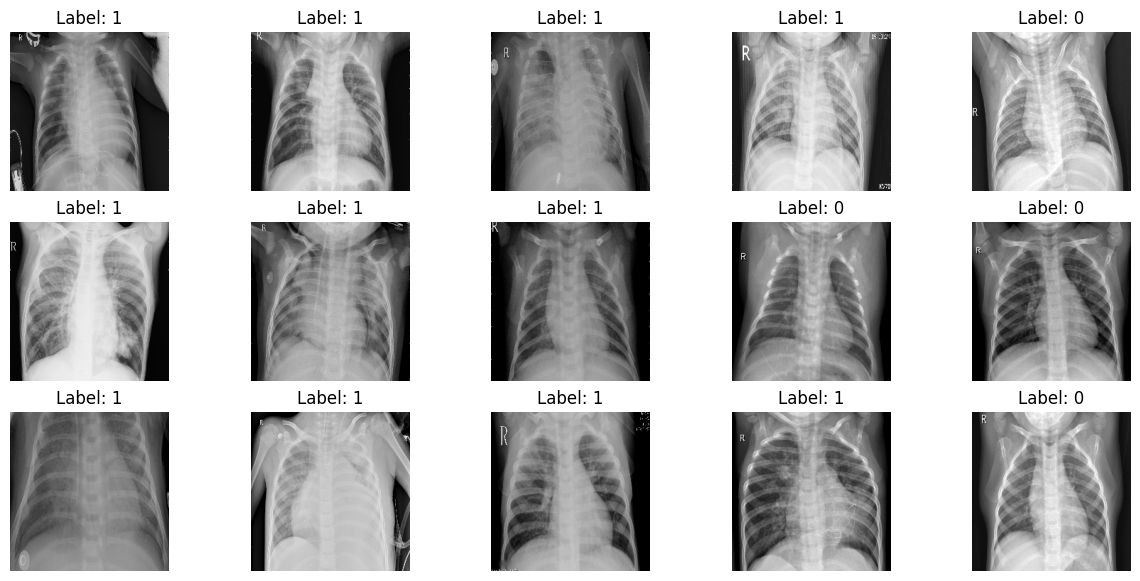

In [46]:
for images, labels in train_ds.take(1):

    plt.figure(figsize=(15, 7))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show()

In [47]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

In [48]:
#  model VGG16 pre-trained
from tensorflow.keras.layers import Flatten, Dense, Dropout # Import Flatten here
input_shape= (224, 224, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model_4 = tf.keras.Sequential()
model_4.add(base_model)
#model_4.add(GlobalAveragePooling2D())
model_4.add(Flatten())
model_4.add(Dense(198, activation='relu'))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(1, activation='sigmoid'))

for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [49]:
model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 198)                 │       4,967,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          25,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,707,911 (75.18 MB)

 Trainable params: 4,993,223 (19.05 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [50]:
#  learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
import os # Import the os module
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Import the necessary classes

checkpoint_filepath4 = '/tmp/checkpoint4.weights.h5'
checkpoint_dir4 = os.path.dirname(checkpoint_filepath4)

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath4, monitor='val_loss',mode='min',
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [52]:
history_4= model_4.fit(train_ds, validation_data=val_ds,
            epochs=200,
            callbacks=callbacks_1, verbose=1)

Epoch 1/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 83s 452ms/step - accuracy: 0.8733 - loss: 2.3583 - val_accuracy: 0.9511 - val_loss: 0.1281 - learning_rate: 0.0100
Epoch 2/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 33s 206ms/step - accuracy: 0.9475 - loss: 0.1471 - val_accuracy: 0.9625 - val_loss: 0.1126 - learning_rate: 0.0100
Epoch 3/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 43s 219ms/step - accuracy: 0.9613 - loss: 0.1014 - val_accuracy: 0.9556 - val_loss: 0.1574 - learning_rate: 0.0100
Epoch 4/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 211ms/step - accuracy: 0.9713 - loss: 0.0842 - val_accuracy: 0.9636 - val_loss: 0.1588 - learning_rate: 0.0100
Epoch 5/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 42s 219ms/step - accuracy: 0.9809 - loss: 0.0627 - val_accuracy: 0.9693 - val_loss: 0.1025 - learning_rate: 0.0020
Epoch 6/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - accuracy: 0.9829 - loss: 0.0441 - val_accuracy: 0.9681 - val_loss: 0.1076 - learning_rate: 0.0020
Epoch 7/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - accura

In [53]:
import numpy as np # Import numpy for numerical operations

def plot_training_history(history_name=None, start_epoch=1):
    if history_name is None:
        raise ValueError("Parameter 'history_name' must be fill with objective (history).")

    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_acc = history_name.history['accuracy']
    val_acc = history_name.history['val_accuracy']
    range_epoch = np.arange(start_epoch, start_epoch + len(train_loss))

    # Get learning rates from the history object if available, otherwise create a list of initial learning rate
    #learning_rate = history_name.history.get('lr', [history_name.model.optimizer.lr.numpy()] * len(train_loss)) # The problem line
    learning_rate = history_name.history.get('lr', [history_name.model.optimizer.learning_rate.numpy()] * len(train_loss)) # Fixed: Use learning_rate

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss', marker='o', color='red')
    plt.plot(range_epoch, val_loss, label='Validation Loss', marker='x', color='blue')
    plt.plot(range_epoch, learning_rate, label='learning_rate', marker='*', color='green')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, train_acc, label='Training Accuracy', marker='o', color='red')
    plt.plot(range_epoch, val_acc, label='Validation Accuracy', marker='x', color='blue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range_epoch)
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    plt.show()

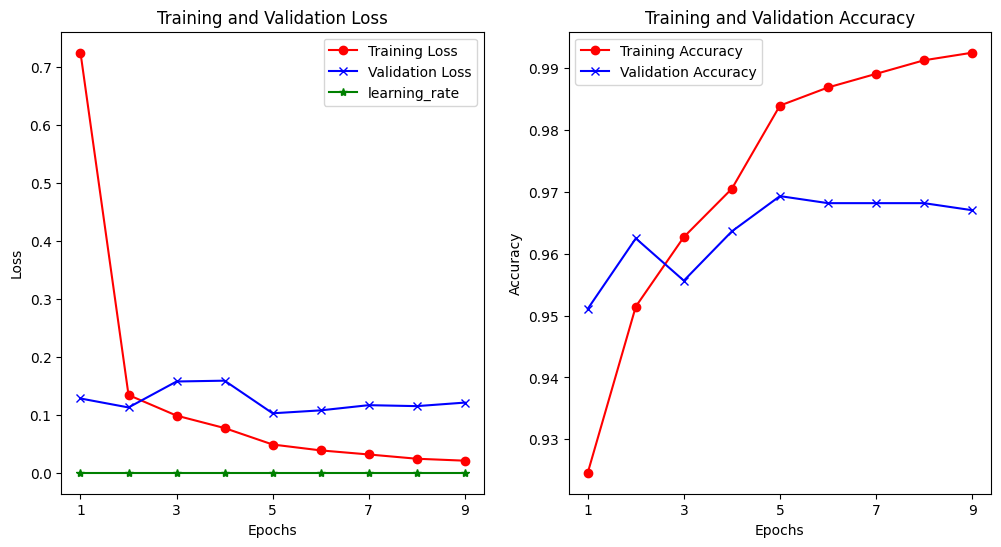

In [54]:
plot_training_history(history_name=history_4)

In [55]:
def evaluate(data=None, model=None):
    loss, acc = model.evaluate(data, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    print("Restored model, loss: {:5.2f}%".format(100 * loss))

In [56]:
model_4.load_weights(checkpoint_filepath4)
evaluate(val_ds,model_4)

28/28 - 5s - 177ms/step - accuracy: 0.9693 - loss: 0.1025
Restored model, accuracy: 96.93%
Restored model, loss: 10.25%


In [57]:
evaluate(train_ds,model_4)

129/129 - 24s - 185ms/step - accuracy: 0.9856 - loss: 0.0340
Restored model, accuracy: 98.56%
Restored model, loss:  3.40%


In [58]:
evaluate(test_ds,model_4)

28/28 - 13s - 460ms/step - accuracy: 0.9772 - loss: 0.0961
Restored model, accuracy: 97.72%
Restored model, loss:  9.61%


In [59]:
model_4.save('model_4.keras')

In [60]:
tf.keras.backend.clear_session()

In [61]:
# Define function to make prediction
def predict_and_evaluate(model, dataset):
    y_true = []
    y_pred = []

    #  Iterate through the dataset to get the actual label and result prediction
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

   # classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report

In [62]:
def calculate_confusion_matrix(model, dataset):
    y_true = []  # Label yang sebenarnya
    y_pred = []  # Label hasil prediksi


    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    #  confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    #Plot confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


    tn, fp, fn, tp = conf_matrix.ravel()
    #tp = conf_matrix[1, 1]
    #p = conf_matrix[0, 1]
    #tn = conf_matrix[0, 0]
    #fn = conf_matrix[1, 0]

    return tp, fp, tn, fn

In [63]:
!pip install -q scikit-learn # Install scikit-learn if needed
from sklearn.metrics import classification_report # Import the function

# Define function to make prediction
def predict_and_evaluate(model, dataset):
    y_true = []
    y_pred = []

    #  Iterate through the dataset to get the actual label and result prediction
    for image, label in dataset:
        predictions = model.predict(image,verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

   # classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report

In [64]:
#Load model
loaded_model_4 = tf.keras.models.load_model('model_4.keras')
classification_report_result = predict_and_evaluate(loaded_model_4, test_ds)
#  classification report
print(classification_report_result)

              precision    recall  f1-score   support

      normal       0.96      0.96      0.96       237
   pneumonia       0.98      0.98      0.98       641

    accuracy                           0.98       878
   macro avg       0.97      0.97      0.97       878
weighted avg       0.98      0.98      0.98       878



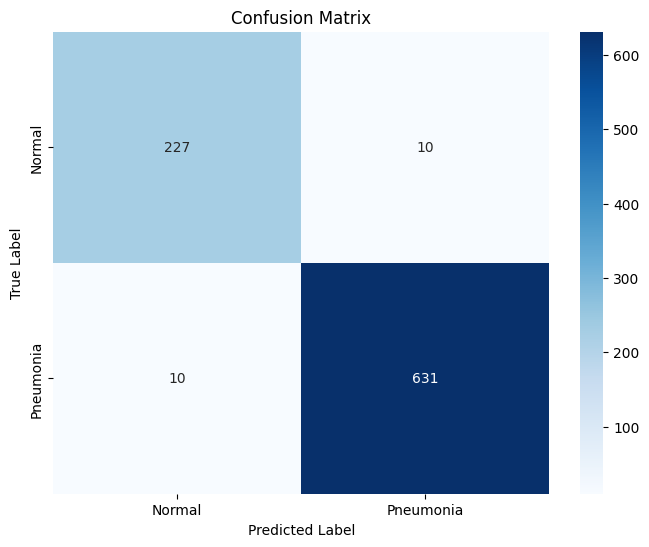

True Positive (TP): 631
False Positive (FP): 10
True Negative (TN): 227
False Negative (FN): 10


In [65]:
!pip install -q scikit-learn
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Increasing confusion matrix by model loading and dataset testing
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_4, test_ds)
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

In [68]:
import torch
loaded_model_4.save("/content/drive/MyDrive/chest_xray_model.keras")
print("✅ Model checkpoint saved.")

# To load the model later, you would use:
# loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/chest_xray_model.keras")

✅ Model checkpoint saved.
